In [123]:
from dotenv import load_dotenv
load_dotenv()

import os
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")
os.environ["HUGGINGFACE_API_KEY"] = os.getenv("HUGGINGFACE_API_KEY")

In [124]:
from langchain_groq import ChatGroq
llm = ChatGroq(model_name="qwen/qwen3-32b")

### To set a command from one agent to another agent

In [125]:
from langgraph.types import Command

### We have a inbuilt ReactAgent from langgraph 

In [126]:
from langgraph.prebuilt import create_react_agent

### Using this command itself we can switch to multiple agents
    - goto : Where to switch to next agent
    - update : What to update in the state


In [127]:
def add_number(state):
    result =state["num1"] + state["num2"]
    return Command(goto="multiply", update={"sum":result})

In [128]:
state = {"num1":10, "num2":20}

In [129]:
add_number(state)

Command(update={'sum': 30}, goto='multiply')

### Creating one dummy MultiAgent
    -> This is for Network Agent or Collaborative Agent

In [130]:
from langchain_core.tools import tool
@tool
def transfer_to_mutiplication_expert():
    """Ask multiplication agnet for help"""
    return 

In [131]:
@tool
def transfer_to_addition_expert():
    """Ask addition agnet for help"""
    return 

In [132]:
llm_with_tools = llm.bind_tools([transfer_to_addition_expert, transfer_to_mutiplication_expert])

In [133]:
response = llm_with_tools.invoke("Hi")

In [134]:
response.content

'Hello! How can I assist you today?'

In [135]:
response.tool_calls

[]

In [136]:
response = llm_with_tools.invoke("what is 2*6")

In [137]:
response.content

''

In [138]:
response.tool_calls

[{'name': 'transfer_to_mutiplication_expert',
  'args': {},
  'id': '20ne6hjhp',
  'type': 'tool_call'}]

In [139]:
from typing_extensions import Literal
from langgraph.graph import MessagesState, StateGraph, START, END

# AGENT 1

In [140]:
def additional_expert(state:MessagesState)-> Command[Literal["multiplication_agent", "__end__"]]:
    
    system_prompt = (
        "You are an addition expert, you can ask the multiplication expert for help with multiplication."
        "Always do your portion of calculation before the handoff."
    )
    
    messages = [{"role": "system", "content": system_prompt}] + state["messages"]
    
    
    ai_msg = llm.bind_tools([transfer_to_multiplication_expert]).invoke(messages)
    
    
    if len(ai_msg.tool_calls) > 0:
        tool_call_id = ai_msg.tool_calls[-1]["id"]
        tool_msg = {
            "role": "tool",
            "content": "Successfully transferred",
            "tool_call_id": tool_call_id,
        }
        
        return Command(
            goto="multiplication_expert", update={"messages": [ai_msg, tool_msg]}
        )
    return {"messages": [ai_msg]}

# AGENT 2

In [141]:
##Agent2
def multiplication_expert(state:MessagesState)-> Command[Literal["additional_agent", "__end__"]]:
    
    system_prompt = (
        "You are a multiplication expert, you can ask an addition expert for help with addition. "
        "Always do your portion of calculation before the handoff."
    )
    
    messages = [{"role": "system", "content": system_prompt}] + state["messages"]
    
    ai_msg = llm.bind_tools([transfer_to_addition_expert]).invoke(messages)
    
    if len(ai_msg.tool_calls) > 0:
        tool_call_id = ai_msg.tool_calls[-1]["id"]
        tool_msg = {
            "role": "tool",
            "content": "Successfully transferred",
            "tool_call_id": tool_call_id,
        }
        return Command(goto="additional_expert", update={"messages": [ai_msg, tool_msg]})
    return {"messages": [ai_msg]}

In [142]:
graph=StateGraph(MessagesState)
graph.add_node("additional_agent",additional_expert)
graph.add_node("multiplication_agent",multiplication_expert)
graph.add_edge(START, "additional_agent")
app=graph.compile()

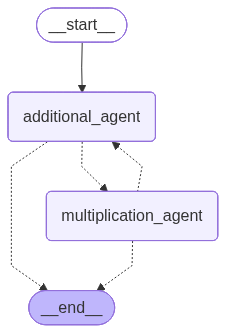

In [143]:
app